# Loading Libraries

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import os
import re
from datetime import datetime
import datetime as dt
import scipy.stats as stats

# Data Set

In [2]:
# loading activity data set
df = pd.read_excel('activity.xlsx')

# Libraries for K-Means

In [3]:
# Loading libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Data Filteration

In [4]:
# Filtering the data for DIM between -3 and 30
df_filtered = df[(df['DIM'] >= -3) & (df['DIM'] <= 30)]

# Feature Selection

In [5]:
# Features
features = ['Activity', 'Rest Time', 'Rest Per Bout', 'Restlessness Ratio', 'Rolling Activity', 'Rolling Rest Time', 'Rolling Rest Per Bout', 
    'Rolling Restlessness Ratio', 'Difference Activity', 'Difference Rest Time', 'Difference Rest Per Bout', 'Difference Restlessness Ratio',
            'Parity', 'DIM']

# Identifiers
identifiers = ['Cow ID', 'Lactation No']

# Concatenation of data based on features

In [6]:
# Aggregation of the data by 'Cow ID' and 'Lactation No'
aggregated_df = df_filtered.groupby(identifiers)[features].mean().reset_index()

# Converting 'DIM' to a categorical feature by rounding (if not already categorical)
aggregated_df['DIM'] = aggregated_df['DIM'].round().astype(int)

# Extraction of Numerical and Categorical features

In [7]:
# Numerical and categorical variables
numerical_features = [feature for feature in features if feature not in ['Parity', 'DIM']]
categorical_features = ['Parity', 'DIM']

# Encoding Numerical and Categorical variables through Standard Scaler and On Hot Encoding

In [8]:
# Encoding the numerical variable through standard scaler and categorical variable through one hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Fitting the Data

In [9]:
# Applying the preprocessor to the aggregated data
aggregated_preprocessed = preprocessor.fit_transform(aggregated_df)

# Elbow Method

In [10]:
# Identifying the optimal number of clusters using the Elbow method
inertia = []

# Setting a range of clusters up to 10
K = range(2, 10)

# Defining a for loop to identify clusters 
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(aggregated_preprocessed)
    inertia.append(kmeans.inertia_)

# Visualization of Elbow method

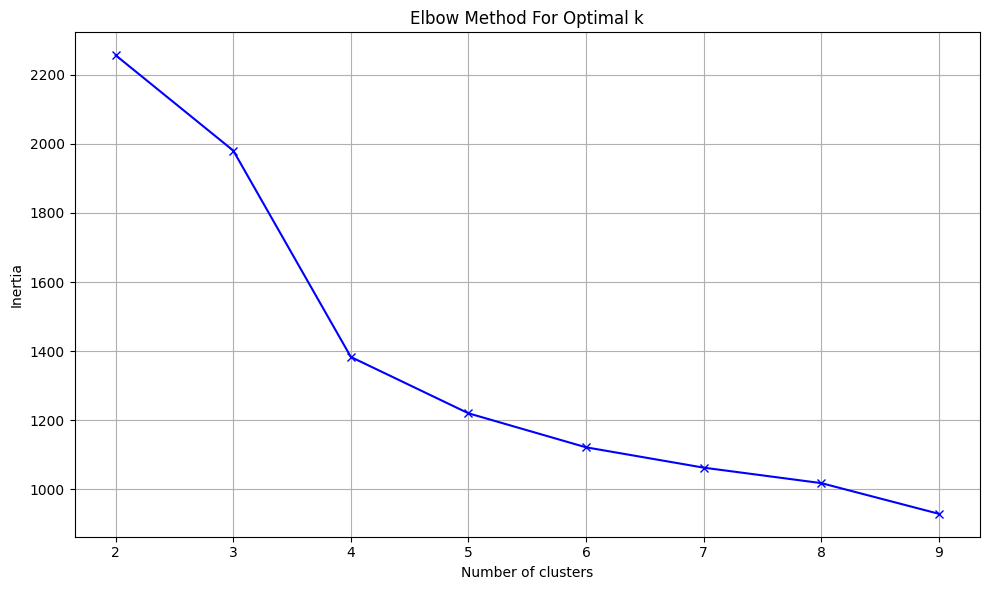

In [11]:
# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.tight_layout()
plt.savefig('elbow.method.png', dpi=300)
plt.show()

# Silhoutte Socre

In [12]:
# Determining the optimal number of clusters using the Elbow Method and Silhouette Score with n_init=10
inertia = []
silhouette_scores = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(aggregated_preprocessed)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(aggregated_preprocessed, kmeans.labels_))

# Visualization of Silhouette Score

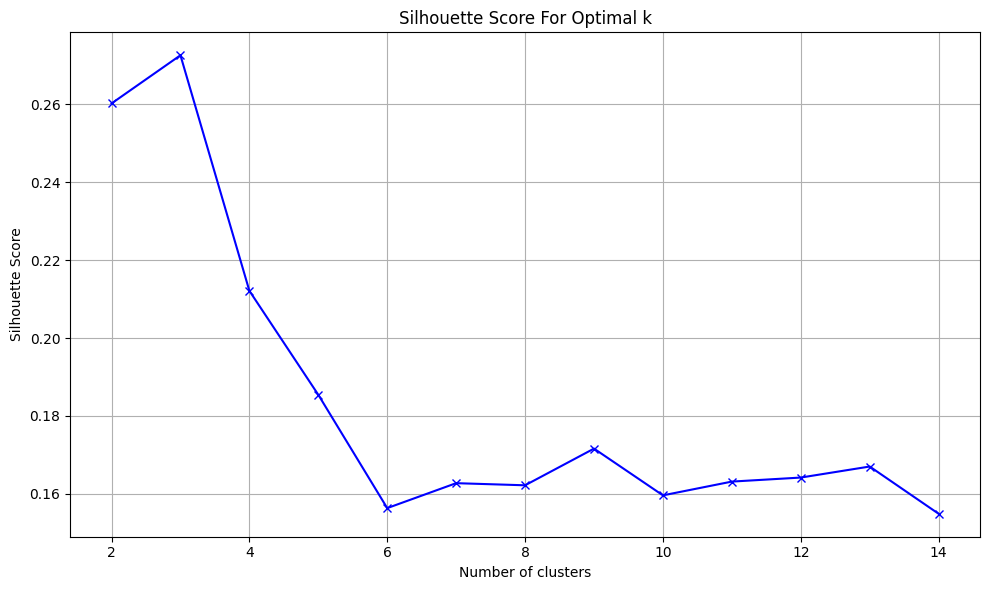

In [13]:
# Plotting the Silhouette Score graph
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.grid()
plt.tight_layout()
plt.savefig('Shilhouette score.png', dpi=300)
plt.show()

# Printing results

In [14]:
# Printing results
optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f'The optimal number of clusters based on Silhouette Score is: {optimal_k}')

The optimal number of clusters based on Silhouette Score is: 3


# K-Means

In [15]:
# Running KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(aggregated_preprocessed)

# Creation of Cluster variable

In [16]:
# Adding the KMeans cluster labels to the aggregated data
aggregated_df['Cluster'] = kmeans_labels

# Cancatenation of Cluster variable with Data set

In [17]:
# Merging the cluster labels back to the original raw data
raw_data_with_clusters = pd.merge(df_filtered, aggregated_df[['Cow ID', 'Lactation No', 'Cluster']], on=['Cow ID', 'Lactation No'], how='left')

# Saving the results

In [18]:
# Exporting the resulting dataframe with clusters to an Excel file
output_file_path = 'Cluster.xlsx'
raw_data_with_clusters.to_excel(output_file_path, index=False)

# Reloading the dataset

In [ ]:
# Load the dataset
file_path = 'Cluster.xlsx'
data = pd.read_excel(file_path)

# Visualization

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from PIL import Image

# Fix for large image warnings
Image.MAX_IMAGE_PIXELS = None  # Disable the decompression bomb warning
import warnings
warnings.simplefilter('ignore', Image.DecompressionBombWarning)



# List of activity parameters
activity_params = ['Rolling Activity', 'Rolling Rest Time', 'Rolling Rest Per Bout', 'Rolling Restlessness Ratio']

# Define parity groups for filtering
parity_groups = {
    'Primiparous': data[data['Parity'] == 1],
    'Multiparous': data[data['Parity'] >= 2]
}

# Cluster variable
cluster_values = sorted(data['Cluster'].unique())

# Define color mapping for clusters
color_mapping = {
    0: 'green',  # Cluster 0
    1: 'blue',   # Cluster 1
    2: 'red'     # Cluster 2
}

# Define y-axis labels
y_labels = {
    'Rolling Activity': 'Rolling Activity (minutes/day)',
    'Rolling Rest Time': 'Rolling Rest Time (minutes/day)',
    'Rolling Rest Per Bout': 'Rolling Rest Per Bout (minutes/bout/day)',
    'Rolling Restlessness Ratio': 'Rolling Restlessness Ratio'
}

# Function to calculate and plot mean and 95% confidence intervals
def plot_with_ci(df, x_column, y_column, cluster_label):
    # Work on a copy to avoid SettingWithCopyWarning
    df = df.copy()
    df.loc[:, x_column] = pd.to_numeric(df[x_column], errors='coerce')
    df.loc[:, y_column] = pd.to_numeric(df[y_column], errors='coerce')
    df = df.dropna(subset=[x_column, y_column])

    # Calculate means, stds, and counts
    means = df.groupby(x_column)[y_column].mean()
    stds = df.groupby(x_column)[y_column].std()
    counts = df.groupby(x_column)[y_column].count()

    # Plot mean line
    color = color_mapping.get(cluster_label, 'gray')
    plt.plot(means.index, means, label=f'Cluster {cluster_label}', color=color, lw=2)

    # Calculate and plot confidence intervals if counts > 1
    if len(counts) > 1:
        ci_upper = means + stats.t.ppf(0.975, counts - 1) * stds / np.sqrt(counts)
        ci_lower = means - stats.t.ppf(0.975, counts - 1) * stds / np.sqrt(counts)
        plt.fill_between(means.index, ci_lower, ci_upper, alpha=0.2, color=color)

# Create a folder for saving plots
save_folder = 'plots_with_white_background'
os.makedirs(save_folder, exist_ok=True)

# Loop through activity parameters to group figures into pairs
display_order = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
image_files = []

for index, feature in enumerate(activity_params):
    # Create a figure for Primiparous and Multiparous cows
    fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)  # Adjusted width to match height
    fig.patch.set_facecolor('white')  # Set background to white

    # Plot for Primiparous cows
    ax = axes[0]
    plt.sca(ax)
    for cluster in cluster_values:
        cluster_data = parity_groups['Primiparous'][parity_groups['Primiparous']['Cluster'] == cluster]
        if not cluster_data.empty:
            plot_with_ci(cluster_data, 'DIM', feature, cluster)
    plt.title(f'{display_order[index]} {feature} of Primiparous Cows', fontsize=16, weight='bold')
    plt.ylabel(y_labels[feature], fontsize=14, weight='bold')
    plt.legend(frameon=False, fontsize=10, loc='upper right', prop={'weight': 'bold'})  # Bold legend, top right
    plt.grid(False)
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.gca().spines[['top', 'right']].set_visible(False)

    # Plot for Multiparous cows
    ax = axes[1]
    plt.sca(ax)
    for cluster in cluster_values:
        cluster_data = parity_groups['Multiparous'][parity_groups['Multiparous']['Cluster'] == cluster]
        if not cluster_data.empty:
            plot_with_ci(cluster_data, 'DIM', feature, cluster)
    plt.title(f'{display_order[index + 1]} {feature} of Multiparous Cows', fontsize=16, weight='bold')
    plt.xlabel('DIM (Days in Milk)', fontsize=14, weight='bold')
    plt.ylabel(y_labels[feature], fontsize=14, weight='bold')
    plt.legend(frameon=False, fontsize=10, loc='upper right', prop={'weight': 'bold'})  # Bold legend, top right
    plt.grid(False)
    plt.xticks(ticks=range(-3, 31, 3), fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.gca().spines[['top', 'right']].set_visible(False)

    # Adjust layout and save
    plt.tight_layout()
    filename = f'{feature}_combined.jpg'.replace(' ', '_')
    file_path = os.path.join(save_folder, filename)
    plt.savefig(file_path, dpi=600, format='jpg', facecolor='white')
    plt.close()
    image_files.append(file_path)

# Combine saved figures into one document if needed
print("Figures saved successfully with white background, adjusted x-ticks, bold legends, and proportional figure sizes.")

Figures saved successfully with white background, adjusted x-ticks, bold legends, and proportional figure sizes.
